In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.cluster import KMeans
import zipfile



In [ ]:
import os
import glob
dataset_path = "img/"
# Pastikan folder ada
if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"Folder tidak ditemukan: {dataset_path}")

image_paths = []
for ext in ("*.jpg", "*.jpeg", "*.png", "*.JPG", "*.PNG"):
    image_paths.extend(glob.glob(os.path.join(dataset_path, "**", ext), recursive=True))

print("Jumlah gambar ditemukan:", len(image_paths))

for path in image_paths[:10]:
    print(path)


Jumlah gambar ditemukan: 18
img\0003_0001.JPG
img\0003_0002.JPG
img\0003_0003.JPG
img\0011_0005.JPG
img\0014_0002.JPG
img\0014_0003.JPG
img\0014_0005.JPG
img\0022_0003.JPG
img\0022_0004.JPG
img\0003_0001.JPG


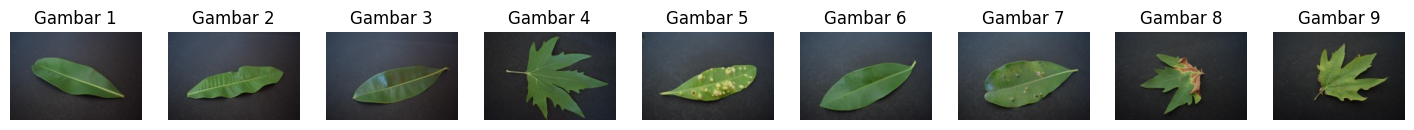

In [ ]:
import matplotlib.pyplot as plt
import cv2

plt.figure(figsize=(18, 9))
for i, path in enumerate(image_paths[:9]):  # tampilkan 9 gambar pertama
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 9, i+1)
    plt.imshow(img)
    plt.title(f"Gambar {i+1}")
    plt.axis('off')
plt.show()


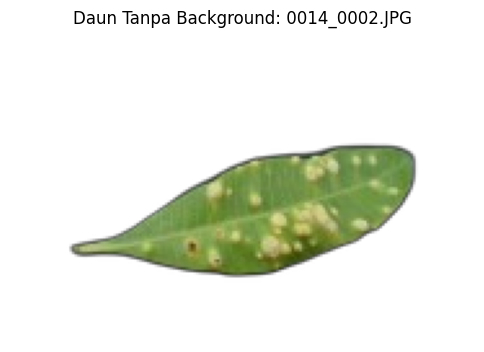

Tipe data gambar: <class 'PIL.Image.Image'>
Mode warna: RGBA
Ukuran gambar: (180, 120)


In [ ]:
import os
from rembg import remove
from PIL import Image
import io
import matplotlib.pyplot as plt

# Use an image path from the already prepared image_paths list
# For example, using the second image as before
image_path = image_paths[4]

# Baca gambar
with open(image_path, "rb") as f:
    input_image = f.read()

# Remove background
output_image = remove(input_image)

# Convert ke PIL Image
result = Image.open(io.BytesIO(output_image)).convert("RGBA")

# Tampilkan hasil
plt.figure(figsize=(6,6))
plt.imshow(result)
# Get the filename for the title
plt.title(f"Daun Tanpa Background: {os.path.basename(image_path)}")
plt.axis("off")
plt.show()

# Info gambar
print("Tipe data gambar:", type(result))
print("Mode warna:", result.mode)
print("Ukuran gambar:", result.size)


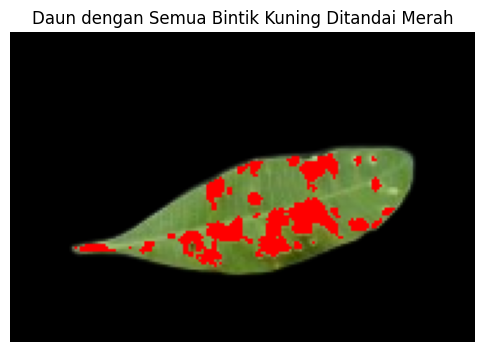

In [12]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
from PIL import Image
import matplotlib.pyplot as plt

# --- 1. Konversi gambar hasil remove background ke array ---
img_rgb = cv2.cvtColor(np.array(result), cv2.COLOR_RGBA2RGB)
h, w, c = img_rgb.shape
img_flat = img_rgb.reshape((-1,3))

# --- 2. Segmentasi daun dengan K-Means ---
k = 2  # 2 cluster: daun vs background
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(img_flat)
labels_2d = labels.reshape(h,w)
centers = kmeans.cluster_centers_.astype(np.uint8)

# Tentukan cluster daun (cluster dengan G lebih tinggi)
green_scores = centers[:,1] - (centers[:,0]+centers[:,2])/2
leaf_cluster_idx = np.argmax(green_scores)
mask_leaf = (labels_2d == leaf_cluster_idx).astype(np.uint8) * 255

# --- 3. Konversi ke HSV untuk mendeteksi bintik kuning di daun ---
img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)

# Range kuning luas untuk bintik (pucat/gelap/terang)
lower_yellow = np.array([15, 50, 150])
upper_yellow = np.array([40, 255, 255])
mask_yellow = cv2.inRange(hsv, lower_yellow, upper_yellow)

# --- 4. Hanya di daun ---
mask_spots = cv2.bitwise_and(mask_yellow, mask_leaf)

# --- 5. Warnai bintik merah ---
img_bgr[mask_spots > 0] = [0,0,255]  # BGR merah

# --- 6. Convert ke PIL dan tampilkan ---
img_result = Image.fromarray(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGBA))
plt.figure(figsize=(6,6))
plt.imshow(img_result)
plt.axis("off")
plt.title("Daun dengan Semua Bintik Kuning Ditandai Merah")
plt.show()


In [ ]:
import numpy as np

# Hitung jumlah pixel bintik
num_bintik = np.sum(mask_spots > 0)
total_daun = np.sum(mask_leaf > 0)
persentase_bintik = (num_bintik / total_daun) * 100

print(f"Jumlah pixel bintik: {num_bintik}")
print(f"Total pixel daun: {total_daun}")
print(f"Persentase area bintik: {persentase_bintik:.2f}%")


Jumlah pixel bintik: 937
Total pixel daun: 3684
Persentase area bintik: 25.43%
